In [1]:
import torch 
import torch.nn as nn
import os
import time
import importlib
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np 
import random
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

import torchvision.transforms as transforms
import torchvision

MAIN REPVGG Apart from main architecture specification I have also included  Reparameterization


In [7]:
def fcbn(conv: nn.Conv2d, bn: nn.BatchNorm2d):

          sf = bn.weight.data / torch.sqrt(bn.running_var + bn.eps) 
          fb = bn.bias.data - sf * bn.running_mean
          fb = fb + sf * conv.bias.data
          fk = sf.view(-1, 1, 1, 1) * conv.weight.data
          # scale_factor = bn.weight.data / torch.sqrt(bn.running_var + bn.eps) 
          # fused_bias = bn.bias.data - scale_factor * bn.running_mean
          # fused_bias += scale_factor * conv.bias.data
          # fused_kernel = scale_factor.view(-1, 1, 1, 1) * conv.weight.data

          return fk, fb

class block(nn.Module):

    def __init__(self,in_channels=None,out_channels=None,stride=None):
        super(block,self).__init__()
        self.stride = stride 
        self.in_channels = in_channels 
        self.out_channels = out_channels
        self.nl = nn.ReLU()
        #self.s = nn.Identity()
        b1 = [nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels,
                                                  kernel_size=(3,3), stride=self.stride, padding=(1,1)),nn.BatchNorm2d(num_features=self.out_channels)]
        self.x = nn.Sequential(*b1)
        b2 = [nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels,
                                                  kernel_size=(1,1), stride=self.stride, padding=(0,0)),nn.BatchNorm2d(num_features=self.out_channels)]
        self.y = nn.Sequential(*b2)
        self.branches = nn.ModuleList([nn.Sequential(*b1),nn.Sequential(*b2)])
        if self.stride == (1,1):
          self.z = nn.BatchNorm2d(num_features=self.in_channels)
          self.branches.append(nn.BatchNorm2d(num_features=self.in_channels))
        else :
          self.z =None


          

    def reparam(self):
        in_ch = self.branches[0][0].weight.data.shape[1]
        out_ch = self.branches[0][0].weight.data.shape[0]

        r = nn.Conv2d(in_channels = in_ch , out_channels =  out_ch,kernel_size= (3,3),
                        padding=(1,1), bias=True, stride=self.branches[0][0].stride)

        fk3 , fb3 = fcbn(*self.branches[0])
        fk1, fb1 = fcbn(*self.branches[1])
        rwd = fk3
        rbd = fb3
        rwd[..., 1:2, 1:2] = rwd[..., 1:2, 1:2] + fk1

        #in case we apply bn layer
        if len(self.branches) == 3:
            sf = self.branches[2].weight.data / (self.branches[2].running_var + self.branches[2].eps).sqrt()
            rwd[range(out_ch), range(in_ch), 1, 1] += sf
            rbd = rbd + self.branches[2].bias.data
            rbd = rbd - sf * self.branches[2].running_mean 

        self.branches = nn.ModuleList([r])


    def forward(self,input):
      #case of reparametrization 
        if len(self.branches)==1 :
          out = self.branches[0](input)
        else :
           if self.z == None :
             out = self.x(input) + self.y(input)
           else :
             out = self.x(input) + self.y(input) +self.z(input)
             out = self.nl(out)
        return out 


class REPVGG(nn.Module):

          def __init__(self,in_channels=3,num_classes=10,blocks=None,multipl=None):
                    super(REPVGG,self).__init__()
                    self.blocks= blocks
                    self.multipl= multipl 
                    self.in_channels = in_channels
                    #self.main_REPVGG = self.main_architecture()
                    self.g = nn.AdaptiveAvgPool2d(output_size=1)
                    self.linear = nn.Linear(int(512 * multipl[3]), num_classes)                               
                    layers = []


                    #stage0

                    
                    multipl = self.multipl
                    out_channels = min(64,int(64*multipl[0])) 
                    in_channels = self.in_channels
                    blocks = self.blocks
                    layers += [block(in_channels = in_channels,out_channels=out_channels,stride = (2,2))]
                    in_channels = min(64, int(64*multipl[0]))




                #stage 1,2 ,3 4 



                    for i in range(4):

                      out_channels = int(64*(2**i) * multipl[i])
                      layers += [block(in_channels = in_channels,out_channels=out_channels,stride = (2,2))]
                      in_channels = out_channels

                      for j in range(blocks[i]-1):
                        layers += [block(in_channels = in_channels,out_channels=out_channels,stride = (1,1))]
                      in_channels = out_channels 
                    self.layers = layers
                    self.main_REPVGG = nn.Sequential(*layers)
          
          def reparametrize(self):
                    for  block in self.layers:
                            block.reparam()


          def forward(self,x):
            x = self.main_REPVGG(x)
            x = self.g(x)
            x = x.view(x.size(0), -1)
            x = self.linear(x)
            return x

In [3]:
transform = transforms.Compose([transforms.Pad(4),transforms.RandomHorizontalFlip(),transforms.RandomCrop(32),transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
test_transform  = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='../../data/', train=True,transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='../../data/', train=False,transform=test_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=100, shuffle=False)

Files already downloaded and verified


### **DIFFERENT TYPES OF REPVGG I have only implemented A1 BECAUSE IT IS SMALLEST but it is recommended to use B2 architecture since according to paper it giver best top1 accuracy all other can be implemented just by changing the arguments  **

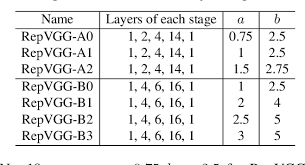

In [ ]:
depth = 2
epochs = 1
batch_size = 256
base_lr = 0.01
lr_decay = 0.0001
milestones = '[80, 120]'
device = "cuda"
num_workers = 3

model = REPVGG(in_channels=3,num_classes=10,blocks=[2, 4, 14, 1],multipl=[0.75, 0.75, 0.75, 2.5]).to(device)
#model = VGG(in_channels = 3, num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=lr_decay)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=lr_decay)
flag = 0 
for epoch in range(epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 50 == 0:
      print ("Epoch {}, Step {} Loss: {:.4f}".format(epoch+1, i+1, loss.item()))
    if loss.item() < 0.1 :
      break 
      flag =1
  if flag == 1:
    break 
 # scheduler.step()

In [9]:
#before model.reparametrized


from torchsummary import summary

model_stats = summary(model, (3, 224, 224))
summary_str = str(model_stats)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 112, 112]           1,344
            Conv2d-2         [-1, 48, 112, 112]           1,344
       BatchNorm2d-3         [-1, 48, 112, 112]              96
       BatchNorm2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 48, 112, 112]             192
            Conv2d-6         [-1, 48, 112, 112]             192
       BatchNorm2d-7         [-1, 48, 112, 112]              96
       BatchNorm2d-8         [-1, 48, 112, 112]              96
             block-9         [-1, 48, 112, 112]               0
           Conv2d-10           [-1, 48, 56, 56]          20,784
           Conv2d-11           [-1, 48, 56, 56]          20,784
      BatchNorm2d-12           [-1, 48, 56, 56]              96
      BatchNorm2d-13           [-1, 48, 56, 56]              96
           Conv2d-14           [-1, 48,

In [10]:
model.reparametrize()

In [11]:
#after reparametrization 
from torchsummary import summary

model_stats = summary(model.to(device), (3, 224, 224))
summary_str = str(model_stats)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 112, 112]           1,344
             block-2         [-1, 48, 112, 112]               0
            Conv2d-3           [-1, 48, 56, 56]          20,784
             block-4           [-1, 48, 56, 56]               0
            Conv2d-5           [-1, 48, 56, 56]          20,784
             block-6           [-1, 48, 56, 56]               0
            Conv2d-7           [-1, 96, 28, 28]          41,568
             block-8           [-1, 96, 28, 28]               0
            Conv2d-9           [-1, 96, 28, 28]          83,040
            block-10           [-1, 96, 28, 28]               0
           Conv2d-11           [-1, 96, 28, 28]          83,040
            block-12           [-1, 96, 28, 28]               0
           Conv2d-13           [-1, 96, 28, 28]          83,040
            block-14           [-1, 96,

In [12]:
output = model(torch.rand(1,3,224,224,device=device)).to(device)
output

tensor([[ 0.0412,  0.0042, -0.0080,  0.0946,  0.0552,  0.0061, -0.1454,  0.0703,
         -0.0457, -0.0019]], device='cuda:0', grad_fn=<AddmmBackward>)

In [13]:
sd = model.state_dict()
print(sd)
#model.main_REPVGG[0].weight

OrderedDict([('linear.weight', tensor([[-4.5761e-03, -9.3680e-05,  1.6860e-02,  ..., -1.0745e-01,
         -3.1544e-03,  7.8824e-03],
        [-5.2576e-03,  8.6329e-04, -1.0384e-03,  ...,  1.1797e-01,
         -7.2613e-03,  5.1205e-03],
        [-4.8487e-03,  3.4898e-03,  2.8930e-03,  ..., -1.4941e-02,
          2.6301e-02, -3.6933e-02],
        ...,
        [-1.3301e-02, -7.5220e-02,  2.2286e-02,  ..., -1.4698e-02,
          2.3383e-02, -1.1121e-02],
        [ 1.6611e-02,  3.4775e-02,  6.1067e-03,  ..., -1.4281e-01,
          4.4360e-03, -4.8917e-04],
        [-2.7456e-02, -1.4730e-02,  1.0594e-02,  ...,  3.4268e-02,
          1.7994e-02,  1.9936e-03]], device='cuda:0')), ('linear.bias', tensor([ 0.0382,  0.0024, -0.0025,  0.0859,  0.0741,  0.0051, -0.1187,  0.0851,
        -0.0693, -0.0053], device='cuda:0')), ('main_REPVGG.0.x.0.weight', tensor([[[[ 0.0708,  0.0577,  0.1348],
          [ 0.2026,  0.3791,  0.1453],
          [ 0.1570,  0.2709,  0.1775]],

         [[-0.0254, -0.0507,

In [15]:
params = []
with torch.no_grad():
  for param in model.parameters():
      params.append(param.view(-1))
  params = torch.cat(params)
  print(params)


tensor([-4.5761e-03, -9.3680e-05,  1.6860e-02,  ...,  3.9824e-03,
        -3.3911e-03, -1.2570e-02], device='cuda:0')


In [14]:
!pip install torchsummary


In [ ]:
model = REPVGG(in_channels=3,num_classes=10,blocks=[2, 4, 14, 1],multipl=[0.75, 0.75, 0.75, 2.5]).to(device)
print(model)


In [ ]:
model.eval()
with torch.no_grad():
    total = 0
    correct =0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy ( test images ) : {} %'.format(100 * correct / total))